Dropped 2.1% entries from factor data: 2.1% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Quantiles Statistics


,min,max,mean,std,count,count %
factor_quantile,,,,,,
1,-27.790829,-0.106001,-1.480381,2.733716,278393,10.015599
2,-0.232022,0.051412,-0.046356,0.059364,277903,9.997971
3,0.022955,0.137955,0.083335,0.024013,277822,9.995057
4,0.111098,0.185511,0.144630,0.014910,277910,9.998223
5,0.149068,0.218534,0.180231,0.012415,278007,10.001712
6,0.170517,0.238400,0.201366,0.012470,277714,9.991171
7,0.184722,0.252764,0.215666,0.012727,277823,9.995093
8,0.195346,0.262821,0.226169,0.013035,277909,9.998187
9,0.202865,0.272928,0.234877,0.013523,277818,9.994913


Returns Analysis


,1D,10D,20D
Ann. alpha,0.044,0.040,0.034
beta,0.206,0.233,0.264
Mean Period Wise Return Top Quantile (bps),6.352,5.896,5.503
Mean Period Wise Return Bottom Quantile (bps),-4.088,-3.935,-3.806
Mean Period Wise Spread (bps),10.440,9.961,9.472


<Figure size 640x480 with 0 Axes>

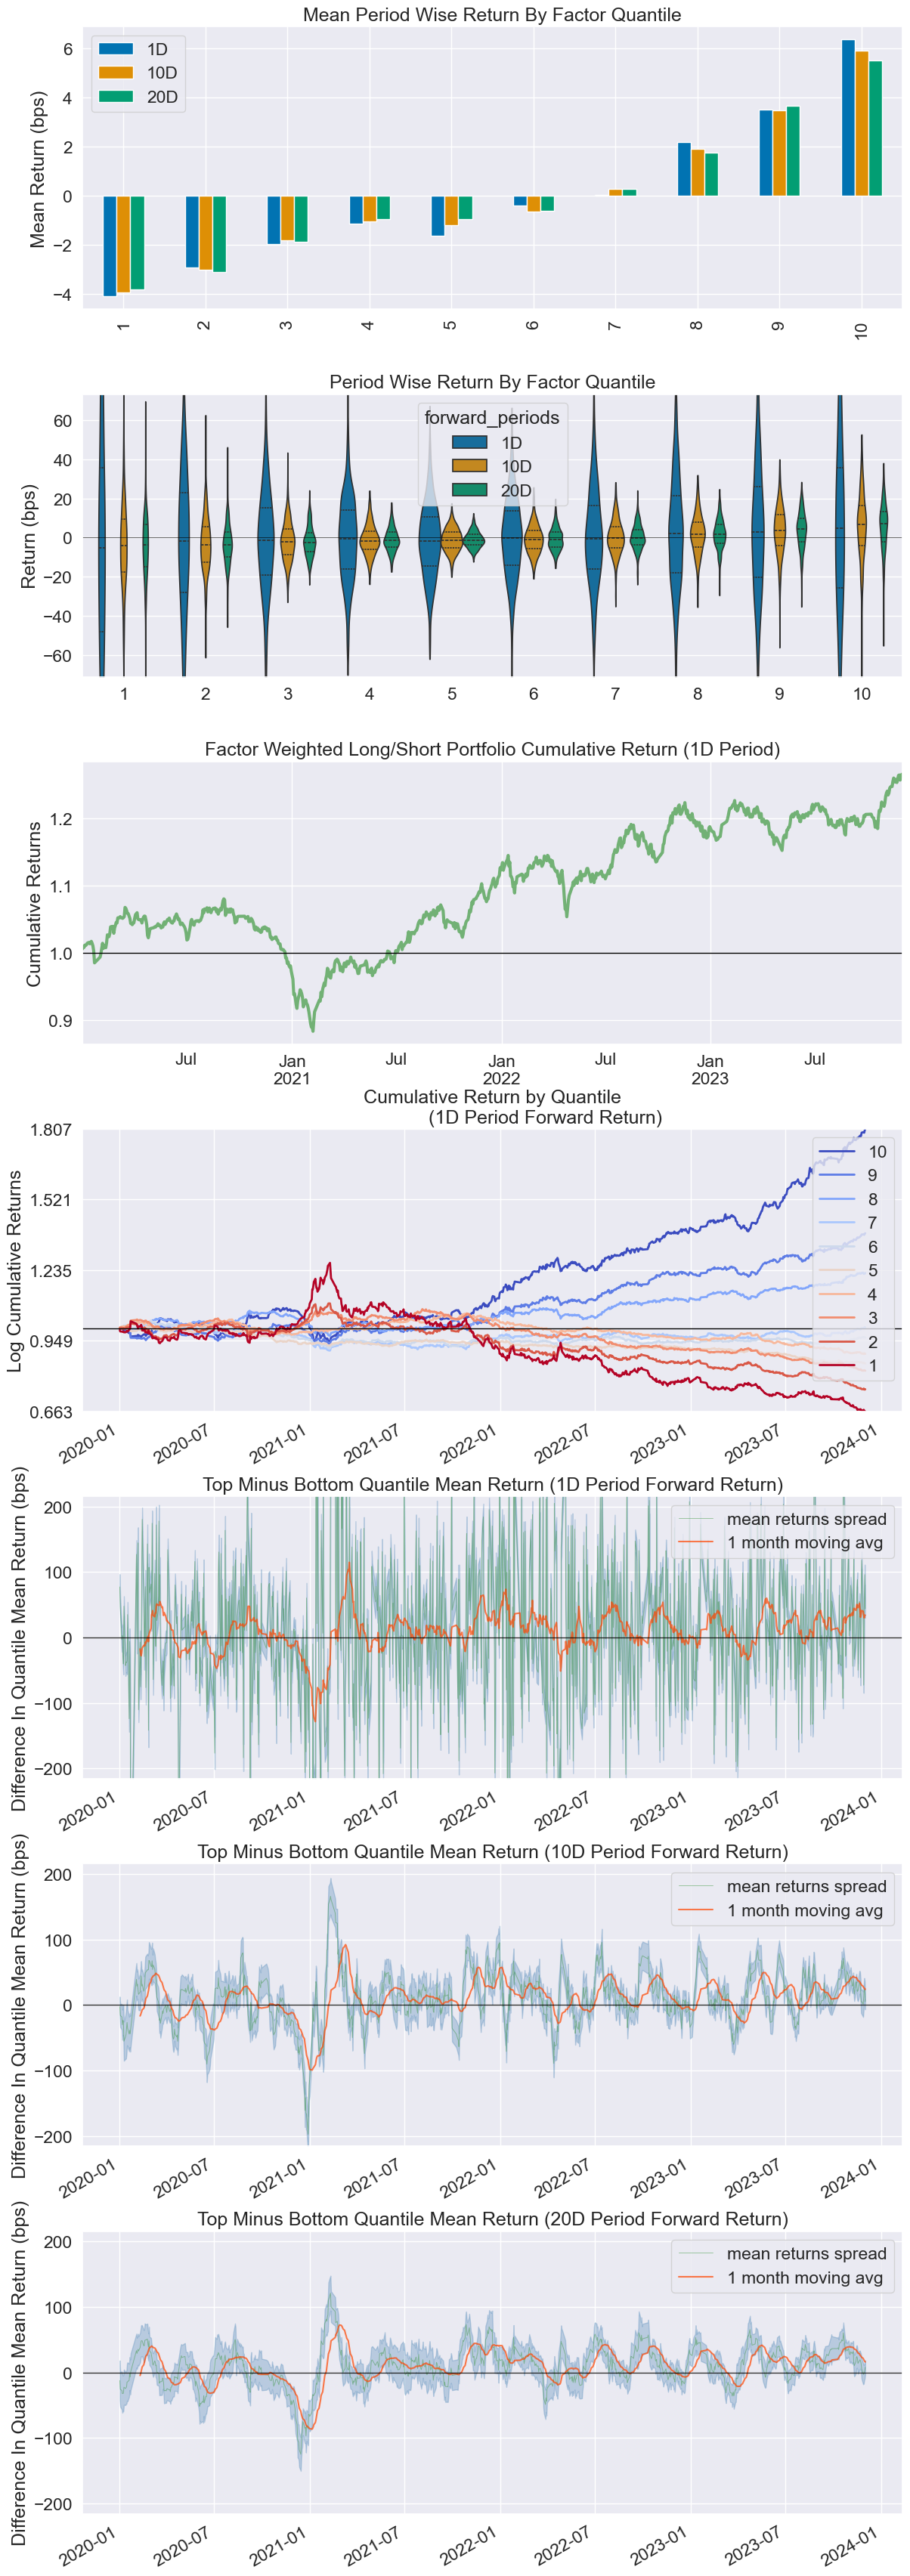

Information Analysis


,1D,10D,20D
IC Mean,0.012,0.036,0.054
IC Std.,0.154,0.162,0.169
Risk-Adjusted IC,0.077,0.220,0.323
t-stat(IC),2.382,6.791,9.948
p-value(IC),0.017,0.000,0.000
IC Skew,0.037,-0.142,-0.261
IC Kurtosis,0.018,0.020,0.132


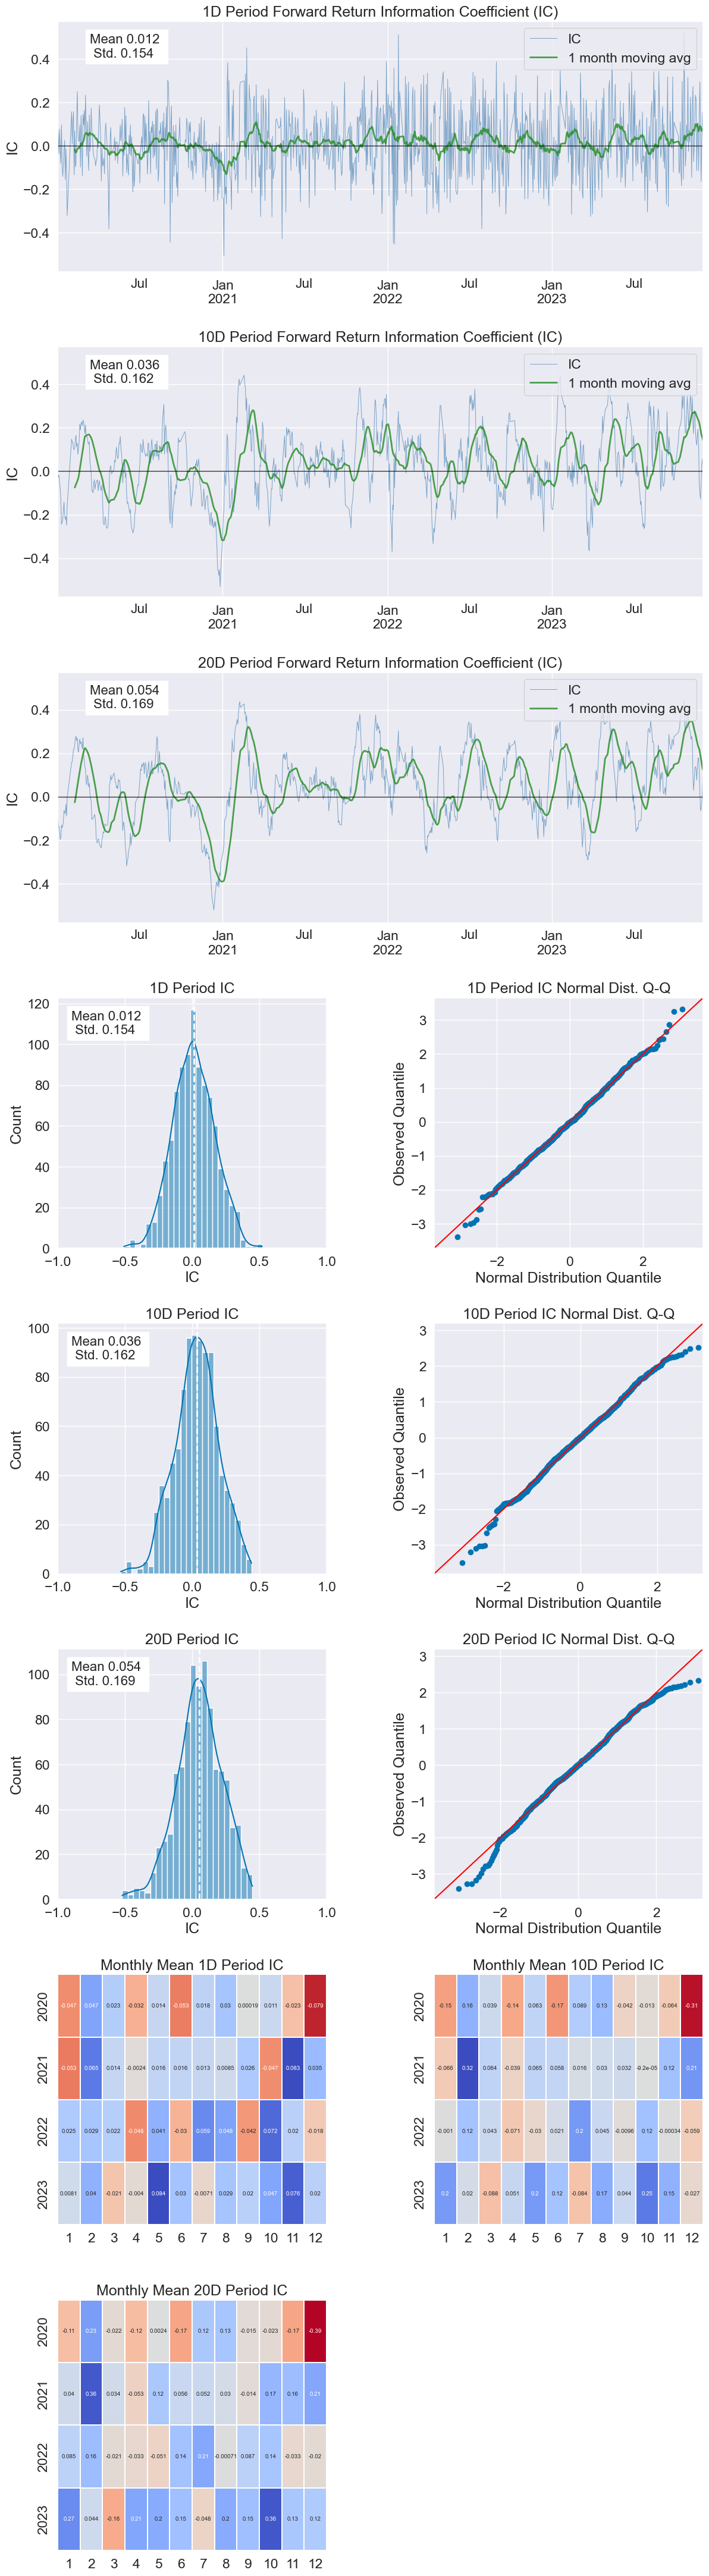

c:\Users\Administrator\AppData\Local\Programs\Python\Python38\lib\site-packages\alphalens\utils.py:929: UserWarning: Skipping return periods that aren't exact multiples of days.
  warnings.warn(


Turnover Analysis


,1D,10D,20D
Quantile 1 Mean Turnover,0.011,0.037,0.053
Quantile 2 Mean Turnover,0.029,0.097,0.139
Quantile 3 Mean Turnover,0.042,0.140,0.201
Quantile 4 Mean Turnover,0.053,0.172,0.243
Quantile 5 Mean Turnover,0.063,0.206,0.288
Quantile 6 Mean Turnover,0.073,0.233,0.324
Quantile 7 Mean Turnover,0.080,0.251,0.343
Quantile 8 Mean Turnover,0.080,0.251,0.341
Quantile 9 Mean Turnover,0.072,0.228,0.309
Quantile 10 Mean Turnover,0.055,0.178,0.244


,1D,10D,20D
Mean Factor Rank Autocorrelation,1.0,0.996,0.992


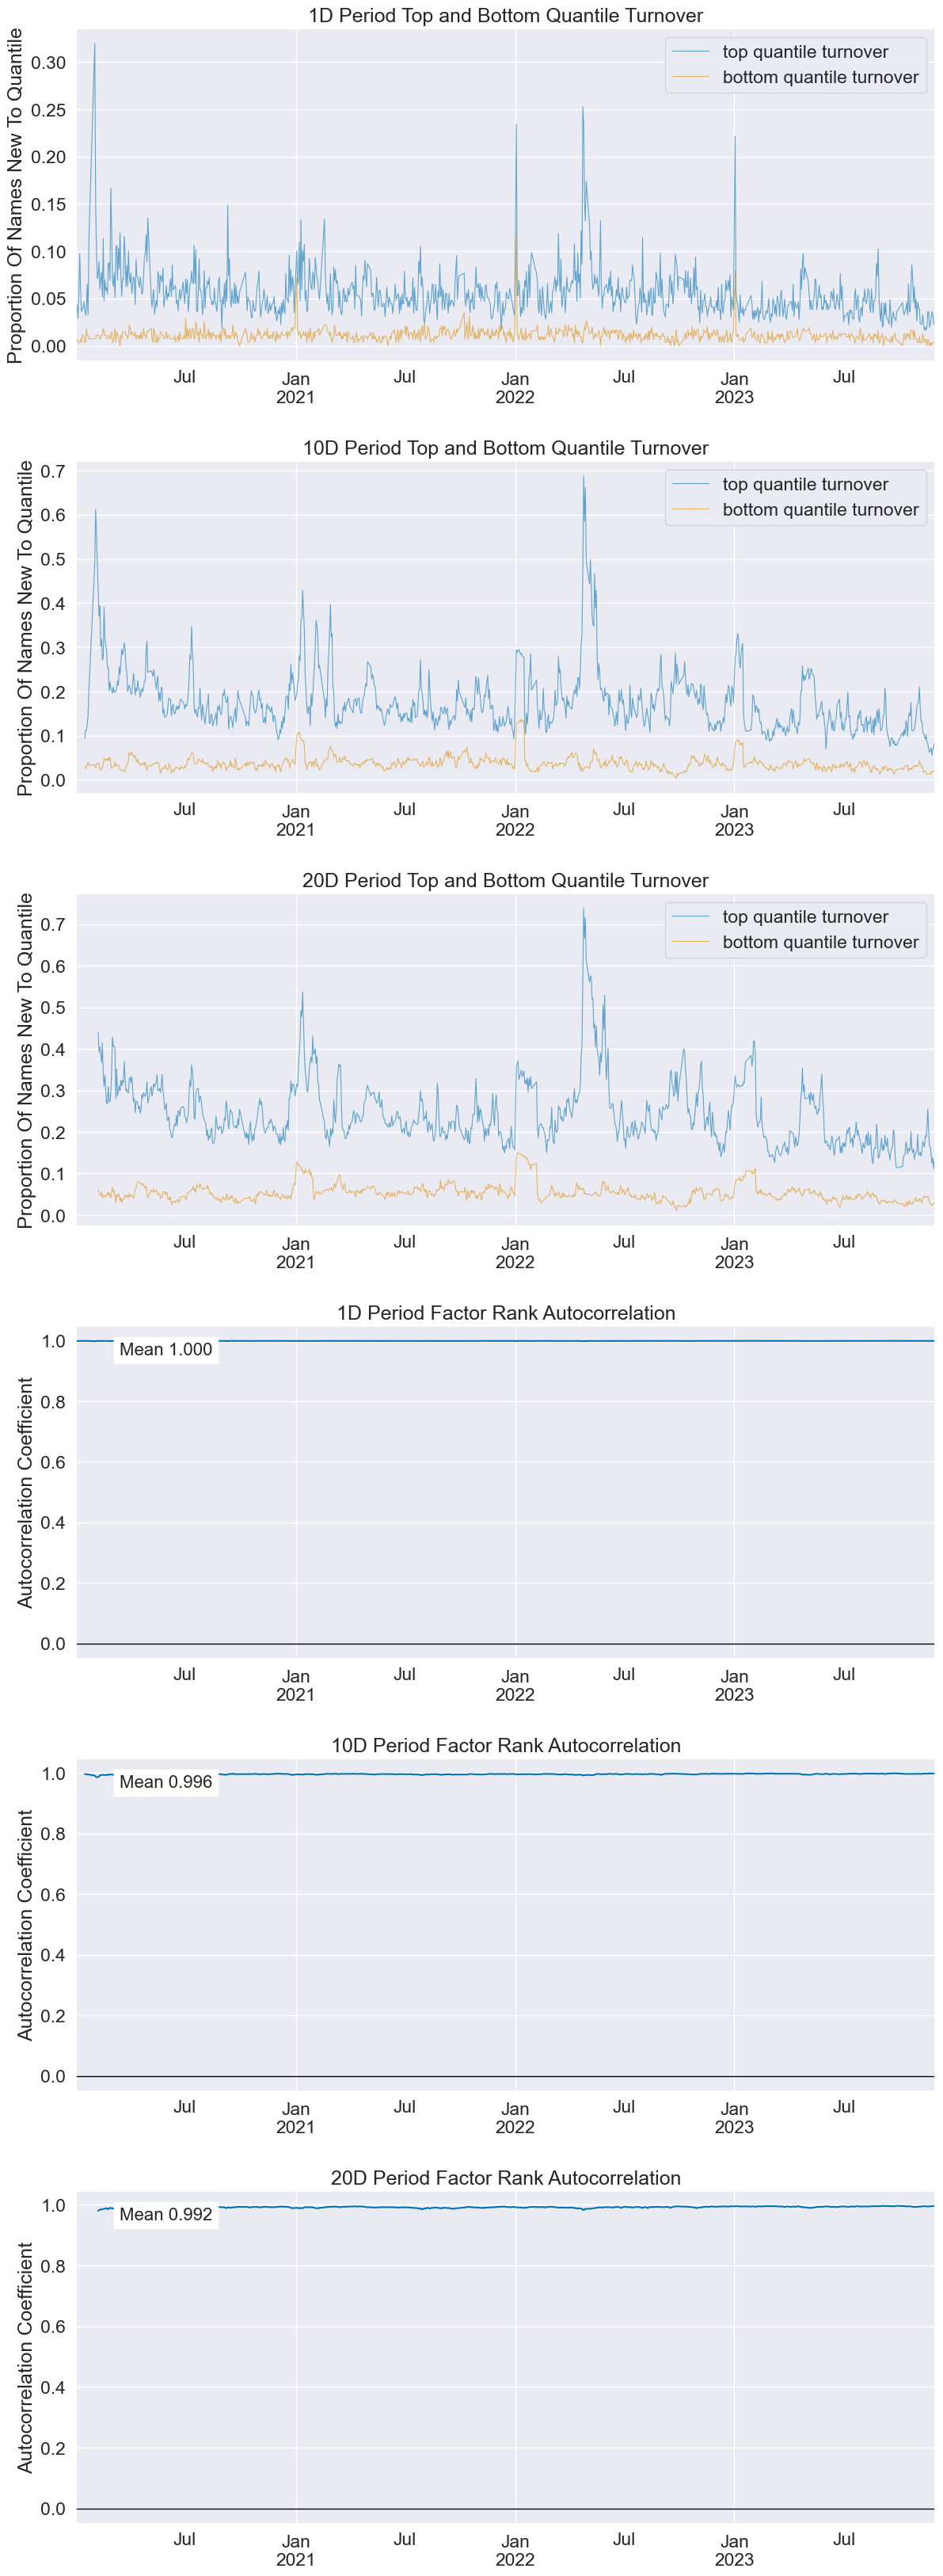

In [ ]:
'''
Author: Van Sun
Date: 2024-04-28 15:26:00
LastEditTime: 2024-05-04 13:46:20
LastEditors: Van Sun
Description: Q4 paper:Hou, Xue, and Zhang (2015) :Digesting anomalies: An investment approach
            四因子模型（市场、市值、投资(最近一个财年 total assets 的变化率)以及盈利(ROE,也有人认为毛利率更好)）
            Q5: Hou, K., H. Mo, C. Xue, and L. Zhang (2018). q^5. NBER Working Paper, No. 24709.
            An Augmented q-factor Model with Expected Growth, Review of Finance.
FilePath: \IFactor\q_factor_model.py

'''
import arcticdb as adb
import numpy as np
from sklearn.preprocessing import StandardScaler
from arcticdb import QueryBuilder
from getTushareData import *
import datetime as dt
from mytools import *
from saveDataToArcticDB import writeDB
import alphalens as al

def get_factor_data(arc_connection,factor_name: str, begin,end):
    start_date = dt.datetime.strptime(begin,'%Y%m%d')
    end_date = dt.datetime.strptime(end,'%Y%m%d')
    q = QueryBuilder()
    q = q[ (q['trade_date']>=start_date)& (q['trade_date']<=end_date)]#f_turnover_rate_f
    from_storage_df = arc_connection.read('factor_basic', \
        columns = ['trade_date', 'ts_code',]+[factor_name], query_builder=q).data
    
    del q
    return from_storage_df

def get_stock_price_data(arc_connection, begin,end):
    start_date = dt.datetime.strptime(begin,'%Y%m%d')
    end_date = dt.datetime.strptime(end,'%Y%m%d')
    q = QueryBuilder()
    q = q[ (q['trade_date']>=start_date)& (q['trade_date']<=end_date)]#close
    from_storage_df = arc_connection.read('stock_price',query_builder=q).data
    del q
    return from_storage_df
    
if __name__ == "__main__":
    ac = adb.Arctic('lmdb://./data/IFactorDB/database?map_size=40GB')
    begin = '20200101'#Backtest from 2010-01-01
    end = '20240101'#Backtest end 2024-04-24
    library = ac['tsData'] 
    pro = ts.pro_api()  
    #取factor
    # from_storage_df = library.read('factor_basic').data
    # factor_df = get_factor_data(library,'f_total_mv',begin,end)
    factor_df = get_factor_data(library,'f_total_mv',begin,end)
    factor_df.set_index(['trade_date','ts_code'], inplace=True)
    
    #取股价
    stock_price_df = get_stock_price_data(library, begin,end)
    stock_price_to_alphalens = stock_price_df.pivot(index='trade_date',columns='ts_code', values='close')
    # print(stock_price_to_alphalens)
    import seaborn as sns
    factor_result = al.utils.get_clean_factor_and_forward_returns(
        factor=factor_df,
        prices=stock_price_to_alphalens,
        quantiles=10,
        periods=(1, 10, 20))
    #一种简化版的报告，省去了图表，只有统计信息
    # al.tears.create_summary_tear_sheet(factor_result, long_short=True, group_neutral=False)
    # factor_returns = al.performance.factor_returns(factor_result)
    # mean_return_by_q_daily, std_err = al.performance.mean_return_by_quantile(\
    # factor_result, by_date=False)

    # # mean_return_by_q_daily.head()
    
    
    # from alphalens.plotting import plot_quantile_returns_bar

    # plot_quantile_returns_bar(mean_return_by_q_daily)
    # sns.despine()
    
    # from alphalens.plotting import plot_quantile_returns_violin
    # #by_date=True!
    # plot_quantile_returns_violin(mean_return_by_q_daily)
    # sns.despine()
    
    # from alphalens.performance import compute_mean_returns_spread
    # from alphalens.plotting import plot_mean_quantile_returns_spread_time_series

    # qrs, ses = compute_mean_returns_spread(mean_return_by_q_daily,upper_quant=10, lower_quant=1,std_err=std_err)

    # plot_mean_quantile_returns_spread_time_series(qrs, ses)
    
    # from alphalens.plotting import plot_cumulative_returns_by_quantile

    # mean_return_by_q_daily, std_err = al.performance.mean_return_by_quantile(factor_result, by_date=True)

    # plot_cumulative_returns_by_quantile(mean_return_by_q_daily, period='20D')
    # sns.despine()
    al.tears.create_full_tear_sheet(factor_result, long_short=True, group_neutral=False, by_group=False)
    # al.tears.create_returns_tear_sheet(factor_result, long_short=True, group_neutral=False, by_group=False)

    # al.tears.create_information_tear_sheet(factor_data, group_neutral=False, by_group=False)

    # al.tears.create_turnover_tear_sheet(factor_data)

    # al.tears.create_event_returns_tear_sheet(factor_data, stock_price_df,
    #                                      avgretplot=(5, 15),
    #                                      long_short=True,
    #                                      group_neutral=False,
    #                                      std_bar=True,
    #                                      by_group=False)
    # al.tears.create_event_returns_tear_sheet(factor_data, stock_price_to_alphalens,
    #                                      avgretplot=(2,10),
    #                                      long_short=True,
    #                                      group_neutral=False,
    #                                      std_bar=False,
    #                                      by_group=False)